# Setup

In [25]:
%%capture
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import scvi
import scipy
from scipy.stats import spearmanr

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
sc.set_figure_params(figsize=(4,4), dpi=80, dpi_save=300, facecolor="white", frameon=False)

In [3]:
os.getcwd()

'/home/joe/Repositories/M-cells/code/WT_AireKO_Fezf2_thymus'

## Set data paths

### demeter

In [4]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

### gardner-lab-computer

In [5]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

## import data

In [6]:
adata = sc.read(f"{processedDataPath}/M_cell/h5ad_files/combined_WT_fezf2KO_aireKO_all_genes.h5ad")
model = scvi.model.SCVI.load(f"{processedDataPath}/M_cell/scVI_models/combined_WT_fezf2KO_aireKO_all_genes", adata=adata)
TRAs = pd.read_csv("../../analysis/TRA_list.csv")["0"]
TRAs = [i for i in TRAs if i in adata.var_names]

INFO     File /mnt/iacchus/joe/processed_data//M_cell/scVI_models/combined_WT_fezf2KO_aireKO_all_genes/model.pt    
         already downloaded                                                                                        


## Methods

### Volcano plot method

In [7]:
def volcano_plot(de, highlight_genes, label_genes=[], highlight_color="red", save_path=None):
    ax = sns.scatterplot(
        x=de.lfc_mean,
        y=de.bayes_factor,
        linewidth=0,
        s=5,
        color="lightgrey",
    )
    ax.grid(False)
    ax.set(xlabel='lfc_mean_WT_vs_KO')
    sns.scatterplot(
        x=de[de.index.isin(highlight_genes)].lfc_mean,
        y=de[de.index.isin(highlight_genes)].bayes_factor,
        linewidth=0,
        s=5,
        color=highlight_color,
    )
    plt.axhline(y=2, color="black", linestyle="dashed")
    plt.axvline(x=-1, color="black", linestyle="dashed")
    plt.axvline(x=1, color="black", linestyle="dashed")
    for gene in label_genes:
        plt.text(
            de[de.index == gene].lfc_mean,
            de[de.index == gene].bayes_factor,
            s=gene,
            color="tab:blue",
            fontdict={"fontsize":12},
        )
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

# Whole dataset DE genes

In [8]:
allClustersDE = model.differential_expression(
    groupby="genotype",
    group1="WT",
    group2="Aire_KO"
)

DE...: 100%|██████████| 1/1 [00:07<00:00,  7.30s/it]


## Filter highly DE genes

In [9]:
filteredAllClustersDE = allClustersDE[allClustersDE.bayes_factor > 2].copy()
filteredAllClustersDE = filteredAllClustersDE[abs(filteredAllClustersDE.lfc_mean) > 1]
filteredAllClustersDE = filteredAllClustersDE[(filteredAllClustersDE.non_zeros_proportion1 > 0.05) | (filteredAllClustersDE.non_zeros_proportion2 > 0.05)]

In [10]:
# Filter genes with low average normalized expression
expressionFiltered = pd.DataFrame(
    pd.DataFrame(
        adata[:, filteredAllClustersDE.index].layers["scVI_normalized"],
        columns=filteredAllClustersDE.index
    ).quantile(0.99)
)
expressionFiltered = expressionFiltered[expressionFiltered[0.99] > 1]
filteredAllClustersDE = filteredAllClustersDE[filteredAllClustersDE.index.isin(expressionFiltered.index)]

## Save CSVs

In [11]:
allClustersDE.to_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters.csv")
filteredAllClustersDE.to_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters_filtered.csv")

# Feature plots

In [12]:
filteredAllClustersDE = filteredAllClustersDE.sort_values(by="lfc_mean", ascending=False)

## Down in KO

In [13]:
allClustersDownKO = filteredAllClustersDE[filteredAllClustersDE.lfc_mean > 0]

## Up in KO

In [14]:
allClustersUpKO = filteredAllClustersDE[filteredAllClustersDE.lfc_mean < 0]
allClustersUpKO = allClustersUpKO.sort_values(by="lfc_mean")

# Volcano plots

## all genes

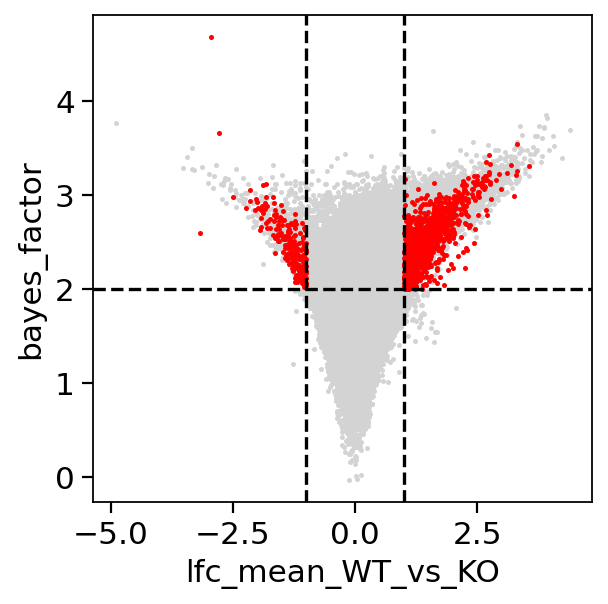

In [15]:
volcano_plot(
    allClustersDE,
    highlight_genes=filteredAllClustersDE.index,
    save_path=("../../analysis/Paper figs/2 (Aire KO)/2G_all_de_genes.pdf")
)

In [16]:
print(len(filteredAllClustersDE[filteredAllClustersDE.lfc_mean > 0]))
print(len(filteredAllClustersDE[filteredAllClustersDE.lfc_mean < 0]))

1155
221


## TRAs

In [17]:
filteredAllClustersDE["TRA"] = filteredAllClustersDE.index.isin(TRAs)
filteredAllClustersDE.to_csv("../../analysis/Aire_WT_vs_KO_DE/all_clusters_filtered_TRAs.csv")

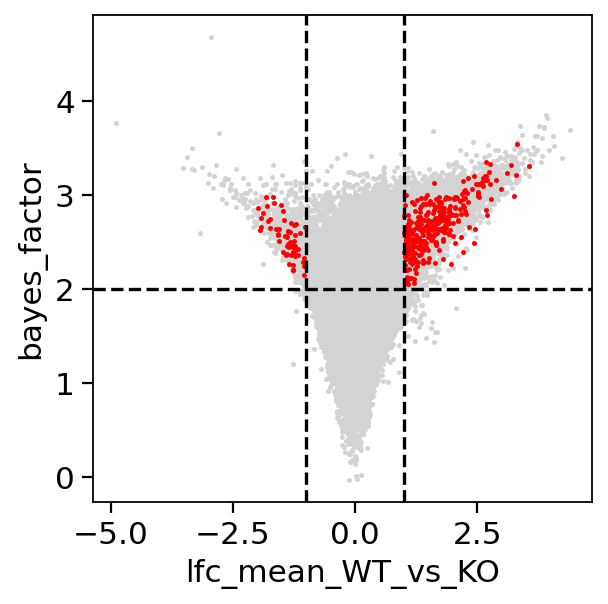

In [18]:
volcano_plot(
    allClustersDE,
    highlight_genes=filteredAllClustersDE[filteredAllClustersDE.TRA].index,
    save_path=("../../analysis/Paper figs/S3 (Aire KO)/S3B_de_TRAs.pdf")
)

In [19]:
print(len(filteredAllClustersDE[filteredAllClustersDE.TRA & (filteredAllClustersDE.lfc_mean > 0)]))
print(len(filteredAllClustersDE[filteredAllClustersDE.TRA & (filteredAllClustersDE.lfc_mean < 0)]))

318
57
